#### Определение стационарности:
* Стационарный временной ряд - это временной ряд, статистические свойства (среднее, дисперсия) которого не меняются со временем. Таким образом, временные ряды с трендами или с сезонностью не являются стационарными - тренд и сезонность будут влиять на значение временного ряда в разные моменты времени. С другой стороны, временной ряд, являющийся белым шумом, является стационарным, поскольку он будет выглядеть примерно одинаково в любой момент времени.
* Тренд-стационарный процесс - это стохастический процесс , из которого можно удалить базовый тренд (функция только времени), оставив стационарный процесс . Тенденция не обязательно должна быть линейной.

In [1]:
# Загружаем нужные библиотеки
import numpy as np
import pandas as pd
from datetime import datetime, date, time
# модуль statsmodels для оценки статистических моделей
import statsmodels.api as sm
# тест Дики-Фуллера из модуля statsmodels
from statsmodels.tsa.stattools import adfuller
# тест KPSS из модуля statsmodels
from statsmodels.tsa.stattools import kpss
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
# импортируем функции для вычисления значений автокорреляционной 
# функции и построения графика автокорреляционной функции
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
# импортируем функции для вычисления значений частной автокорреляционной 
# функции и построения графика частной автокорреляционной функции
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# импортируем библиотеку cryptocompare 
# для возможности загрузки котировок
import cryptocompare
# Установим API-ключ для работы с cryptocompare
cryptocompare._set_api_key_parameter(
    '4a5dc36093b98571418a67c8347973dd5cda0b960be6383e86e31d83079316c0')

D:\Miniconda3_W11\envs\fl3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


'&api_key=4a5dc36093b98571418a67c8347973dd5cda0b960be6383e86e31d83079316c0'

# Зададим базовые значения для дальнейших расчетов:

In [2]:
# Интересующий нас символ криптовалюты(к примеру 'DOGE' или 'BTC')
FSYM = 'DOGE'

# Символ валюты в которую конвертируется(к примеру 'RUB' или 'USD')
TSYM = 'RUB'

# Период графика(к примеру день - 'D' или час - 'H')
PERIOD = 'H'   # 'D'  'H'  

# Время с которого начинается загрузка котировок.
# Например -  datetime.datetime(2014,9,1)
# если нужна загрузка с самого начала существующих данных,
# то пишем - 0
FROMTS = datetime(2021,2,15)

# Время до которого качаем котировки,
# Например -  datetime(2022,3,19)
# если нужна загрузка до текущего момента,
# то пишем - datetime.now()
TOTS = datetime(2021,3,20)  #      datetime.now()     

# Зададим биржу с которой будут браться данные
# Например - 'Kraken'
# Если же хотим взять агрегированный индекс объединяющий данные 
# о транзакциях из более чем 70 бирж, т.е. индекс CCCAGG,
# то пишем - 'CCCAGG'
EXCHANGE = 'CCCAGG'

# Значение по которому будем анализировать 
# Например по цене открытия свечи - 'open'
# или же по цене закрытия свечи - 'close'
CANDLE_DATA = 'close'  # 'open','close','high','low'

# Критическое значение с доверительным интервалом в процента,
# которое будет использоваться в расчетах в тестах Дики-Фуллера
# и тесте KPSS (Kwiatkowski-Phillips-Schmidt-Shin).
# Обычно для оценки стационарности берется критическое значение 
# с доверительным интервалом - 5%
CRITICAL_VALUE = '5%'

In [3]:
# Если нужно, можно посмотреть все доступные для анализа символы криптовалют

print(cryptocompare.get_coin_list(format=True))

['XBS', 'XPY', 'PRC', 'YBC', 'DANK', 'GIVE', 'KOBO', 'DT', 'CETI', 'SUP', 'XPD', 'GEO', 'CHASH', 'NXTI', 'WOLF', 'XDP', '2015', '42', 'ACOIN', 'ALF', 'AEGIS', 'ALIEN', 'APEX', 'ARCH', 'ARG', 'ARI', 'AXR', 'BLU', 'BOST', 'BQC', 'XMY', 'ZET', 'SXC', 'QTL', 'ENRG', 'RIC', 'LIMX', 'BTB', 'CAIX', 'BTMK', 'BUK', 'CACH', 'CANN', 'CAP', 'CASH', 'CBX', 'CCN', 'CIN', 'CINNI', 'CXC', 'CLAM', 'CLR', 'CNL', 'COMM', 'COOL', 'CRACK', 'CRYPT', 'DEM', 'DIAM', 'DRKC', 'DSB', 'EAC', 'EFL', 'ELC', 'EMD', 'EXCL', 'EZC', 'FLAP', 'FC2', 'FFC', 'FIBRE', 'FRC', 'FLT', 'FRK', 'FRAC', 'FSTC', 'GDC', 'GLYPH', 'GML', 'GUE', 'HAL', 'HBN', 'HUC', 'HVC', 'HYP', 'ICB', 'IFC', 'IXC', 'JBS', 'JKC', 'JUDGE', 'KDC', 'KEYC', 'KGC', 'LK7', 'LKY', 'LSD', 'LTCD', 'LTCX', 'LXC', 'LYC', 'MAX', 'MINRL', 'MINC', 'MRY', 'MZC', 'NAN', 'NAUT', 'NET', 'NMB', 'NRB', 'NOBL', 'NRS', 'NYAN', 'ORB', 'OPSC', 'PHS', 'POINTS', 'PSEUD', 'PXC', 'PYC', 'RIPO', 'RPC', 'RT2', 'RYC', 'RZR', 'SAT2', 'SBC', 'SDC', 'SFR', 'SHADE', 'SHLD', 'SILK', 'SL

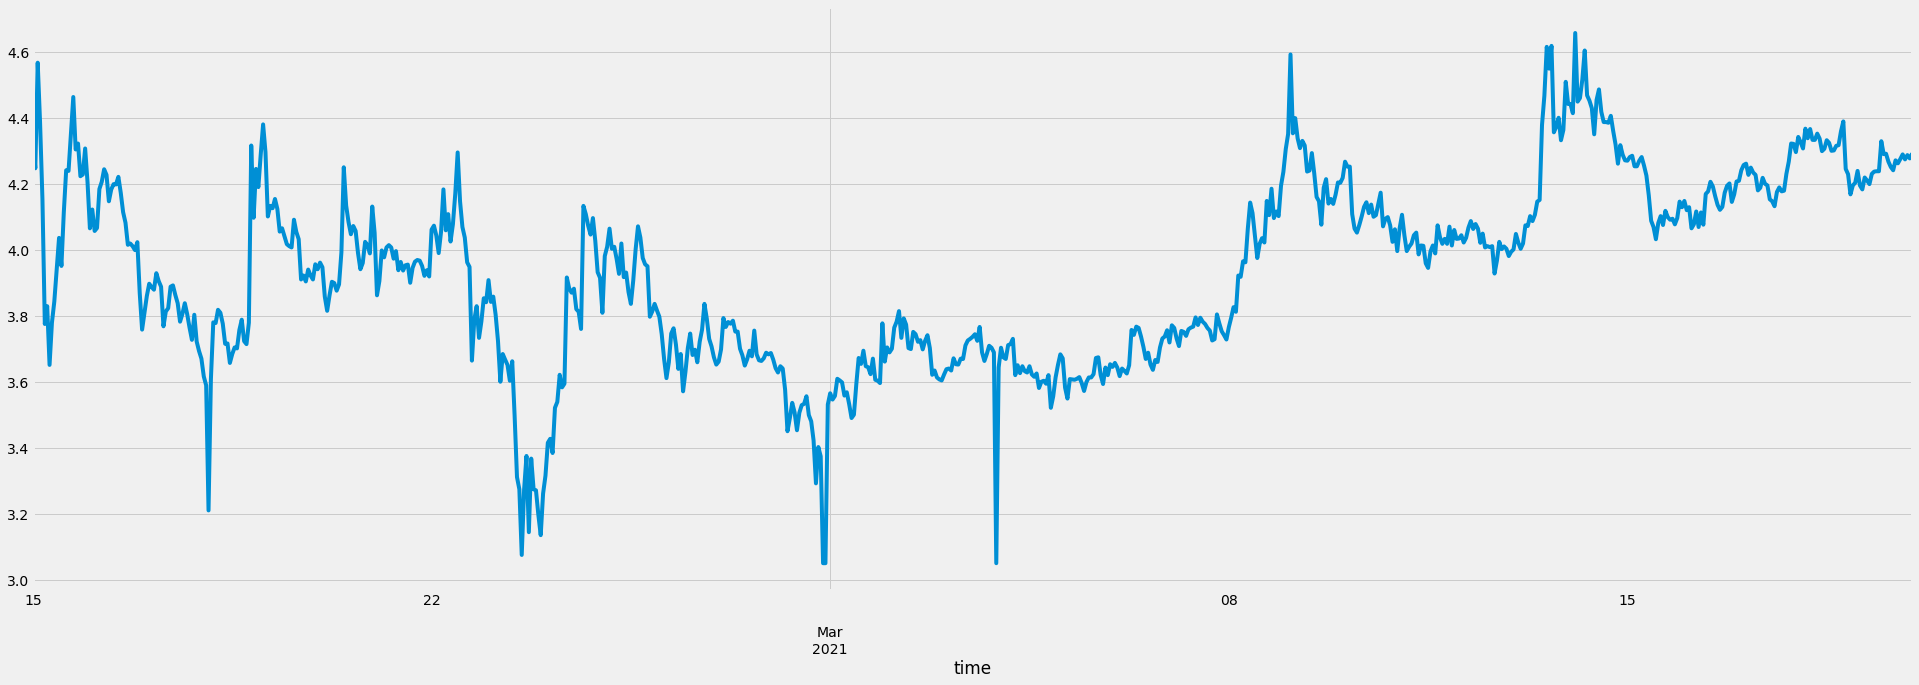

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2021-02-15 00:00:00,4.421,4.341,4.354,922086.57,4002773.84,4.341,multiply,ETH
2021-02-15 01:00:00,4.338,4.248,4.341,1980571.92,8412579.38,4.248,multiply,ETH
2021-02-15 02:00:00,4.622,4.122,4.248,19314605.60,88220416.86,4.568,multiply,ETH
2021-02-15 03:00:00,4.621,4.387,4.568,9896739.61,43414591.47,4.387,multiply,ETH
2021-02-15 04:00:00,4.266,4.121,4.387,14213441.39,59039304.22,4.154,multiply,ETH
...,...,...,...,...,...,...,...,...
2021-03-19 20:00:00,4.307,4.275,4.276,1072901.56,4602654.45,4.290,multiply,ETH
2021-03-19 21:00:00,4.286,4.269,4.290,990997.38,4236915.37,4.275,multiply,ETH
2021-03-19 22:00:00,4.300,4.283,4.275,665653.94,2854580.84,4.288,multiply,ETH


In [4]:
# Загрузка исторических данных с заданными ранее параметрами
if PERIOD == 'D':
    df = pd.DataFrame(
        cryptocompare.get_historical_price_day_from(
            FSYM, 
            TSYM, 
            exchange=EXCHANGE, 
            fromTs = FROMTS,
            toTs=TOTS
            ))
elif PERIOD == 'H':
    df = pd.DataFrame(
        cryptocompare.get_historical_price_hour_from(
            FSYM, 
            TSYM, 
            exchange=EXCHANGE, 
            fromTs = FROMTS,
            toTs=TOTS
            ))


# Преобразуем столбец со временем у нужный формат и сделаем 
# его индексом датафрейма
df['time'] = [datetime.fromtimestamp(d) for d in df['time']]
df = df.set_index('time')

# визуализируем временной ряд, для визуальной оценки на стационарность ряда 
df[CANDLE_DATA].plot(figsize=(30, 10))
plt.show()

# Посмотрим на данные
display(df)

#### Так же можно с помощью библиотеки statsmodels сделать автоматическую декомпозицию ряда на составляющие - Тренд, Сезонность, Остатки:

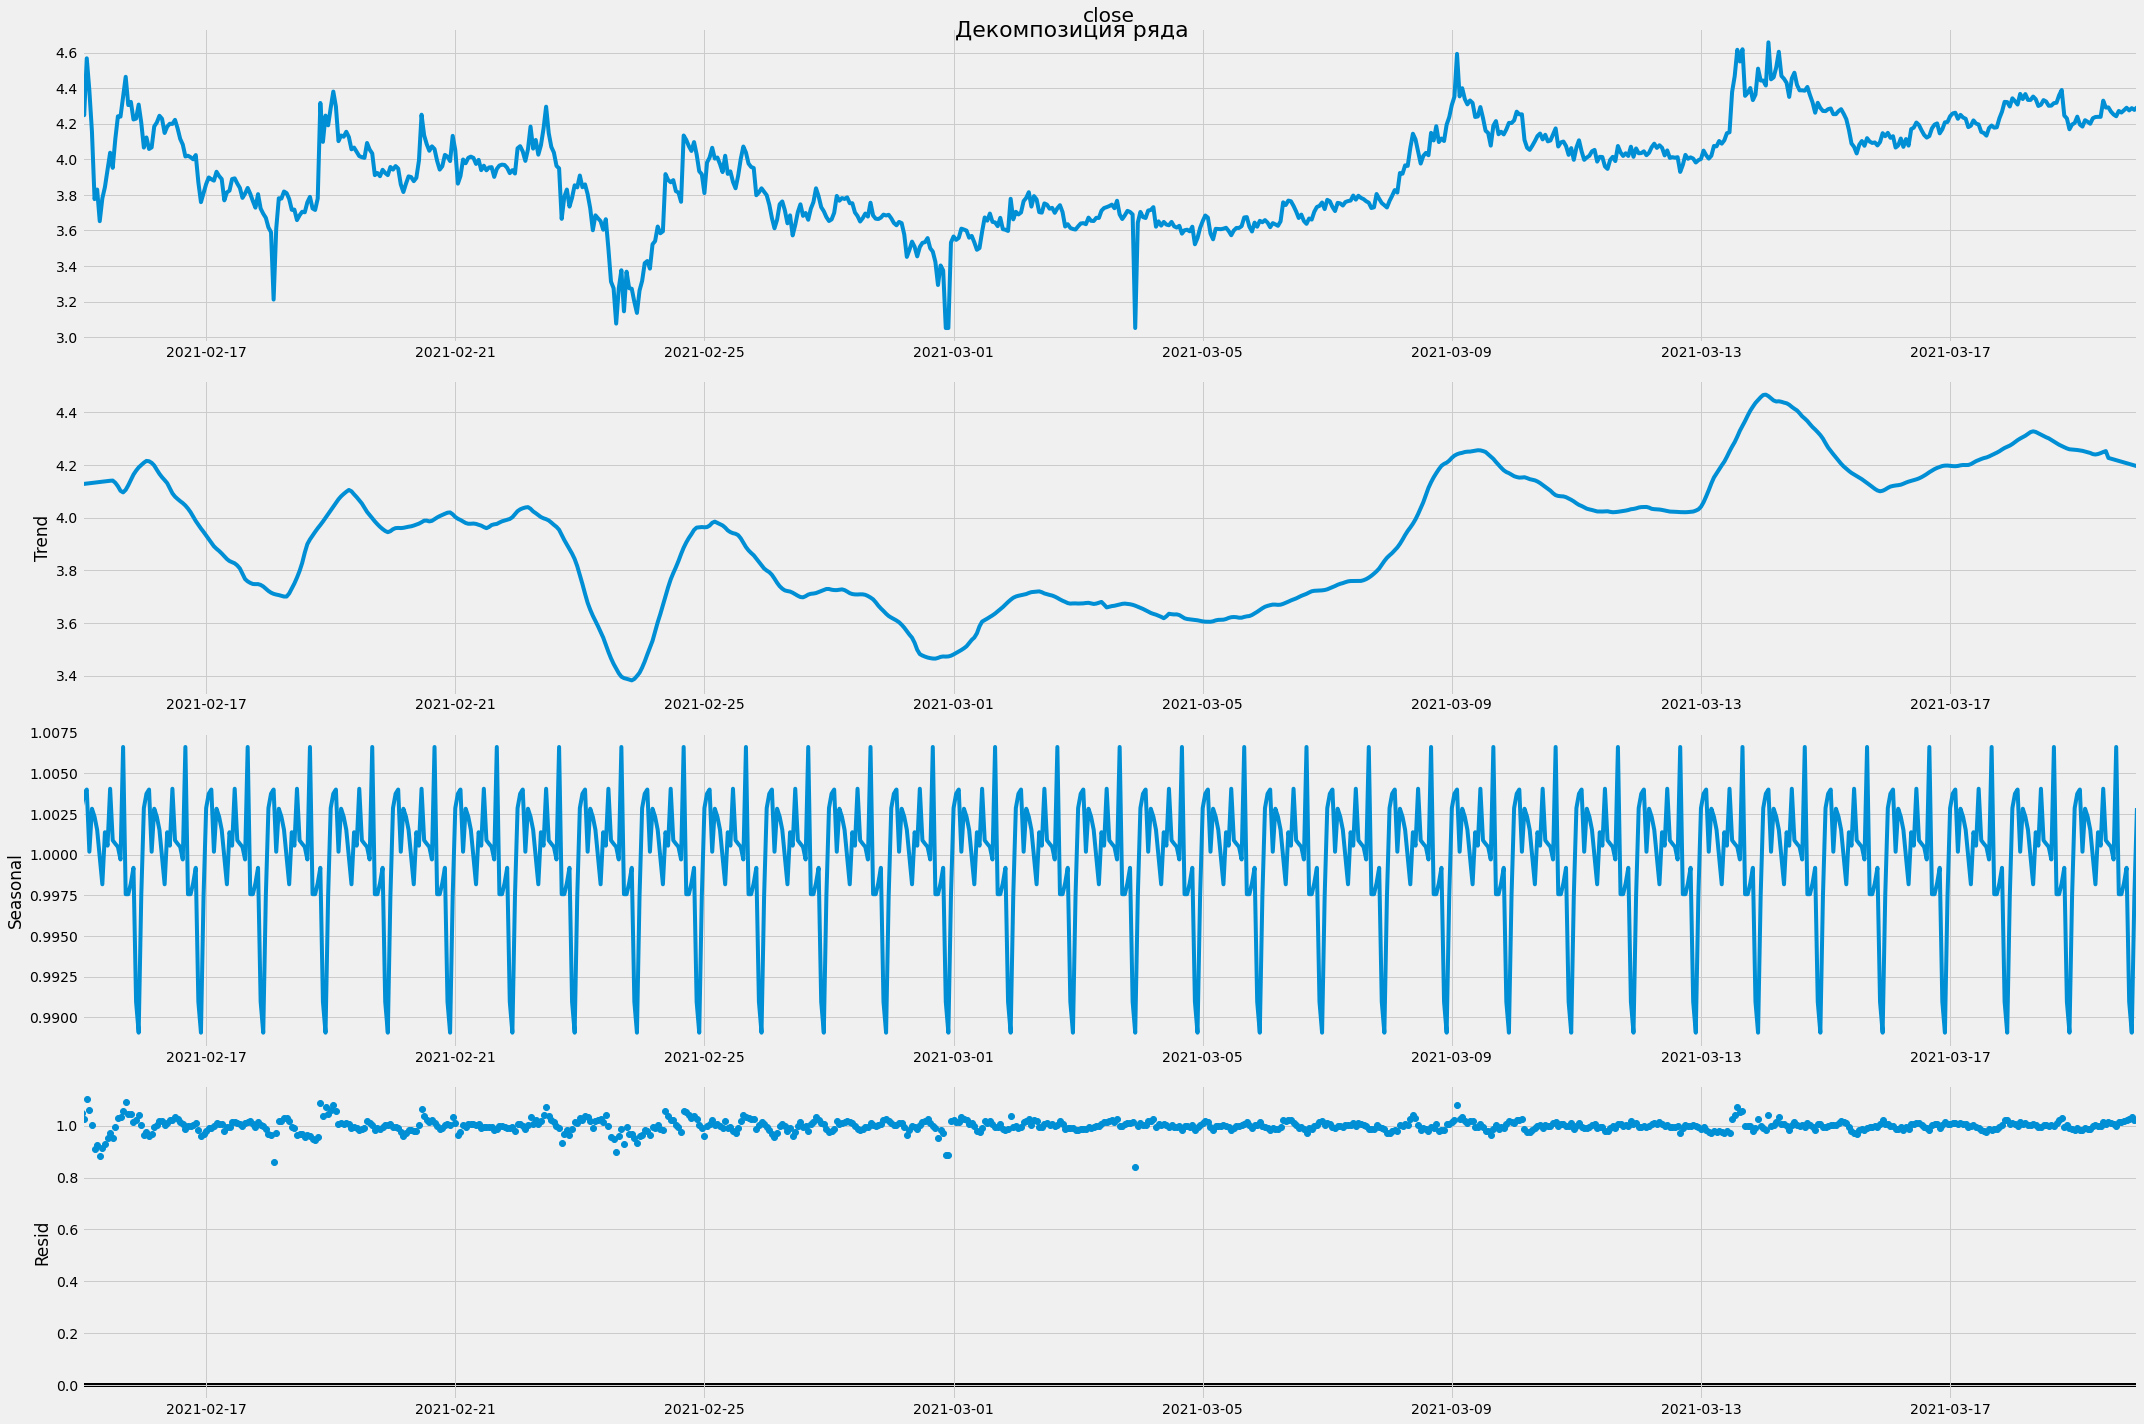

In [5]:
# Декомпозиция ряда на составляющие - Тренд, Сезонность, Остатки:
result_mul = seasonal_decompose(df[CANDLE_DATA], model='multiplicative', extrapolate_trend='freq')

# Отрисовка графиков
plt.rcParams.update({'figure.figsize': (30,20)})
result_mul.plot().suptitle('Декомпозиция ряда', fontsize=22)
plt.show()

<AxesSubplot:xlabel='time'>

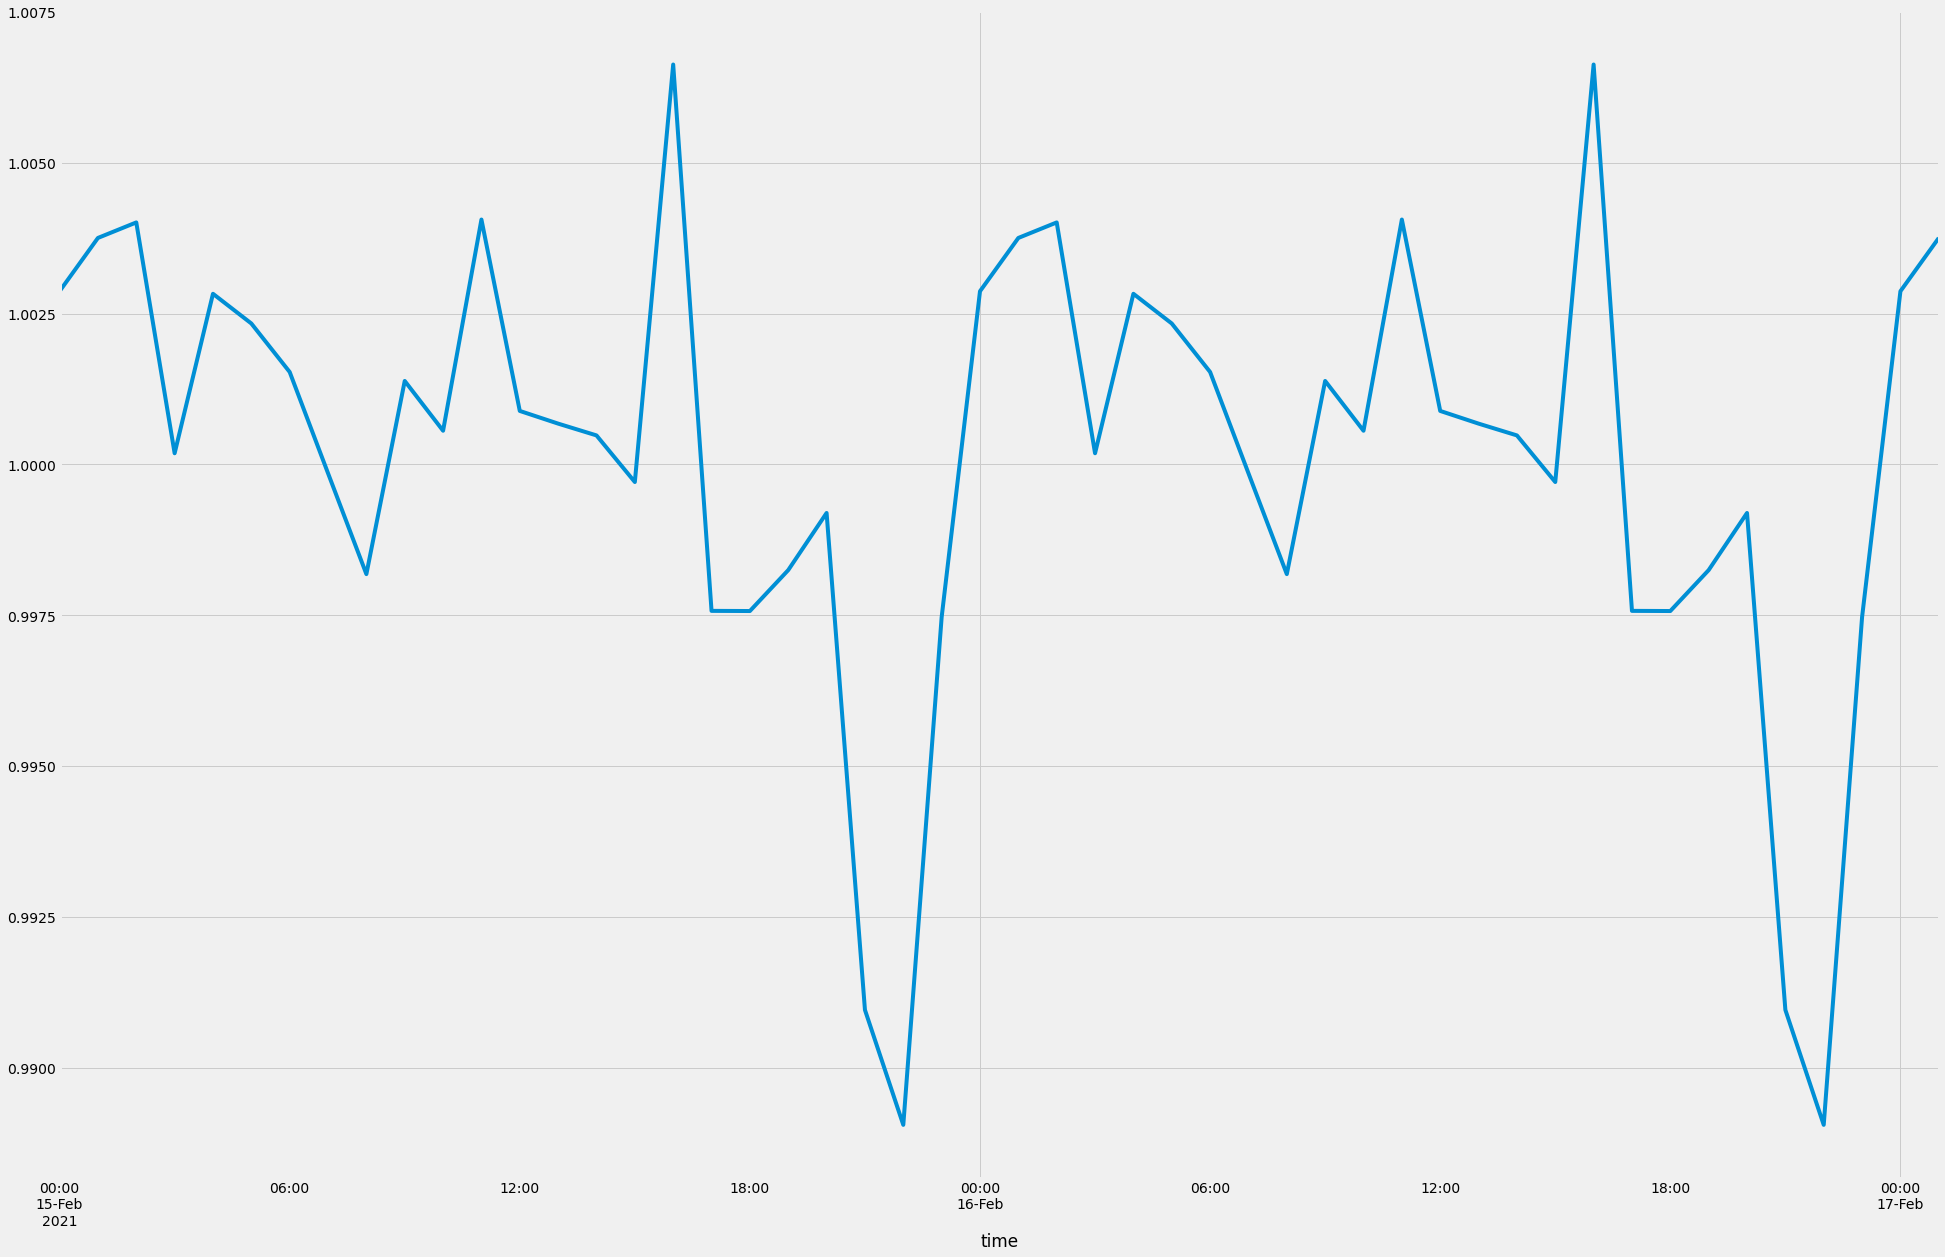

In [6]:
# Можно посмотреть сезонность в более увеличенном маштабе,
# чтобы точнее определить ее период(на крипте она обычно 24 часа)
result_mul.seasonal[:50].plot()

# Расширенный тест Дики-Фуллера, Augmented Dickey–Fuller test ( ADF )
#### Этот тест используется для оценки того, является ли временной ряд стационарным. 
* Нулевая гипотеза: ряд имеет единичный корень и не стационарен.
* Отклонение нулевой гипотезы означает, что временной ряд стационарен
#### Не вдаваясь в подробности тестирования гипотез, нужно знать, что этот тест даст результат, называемый «тест-статистика», на основе которого можно сказать, с различными уровнями (или процентами доверительного интервала) достоверности, является ли временной ряд стационарным или нет. 
#### Обычно для оценки стационарности берется  критическое значение с доверительным интервалом -  5%
#### Результаты теста: тесты Дики-Фуллера выводят следующие результаты - статистика теста, значение p и критическое значение с доверительными интервалами 1%, 5% и 10%

### Тест на стационарность: если тестовая статистика меньше критического значения, мы можем отвергнуть нулевую гипотезу (то есть ряд является стационарным). Когда статистика теста больше критического значения, мы не можем отклонить нулевую гипотезу (что означает, что ряд не является стационарным).

###### Так как ряд которые мы анализируем в любом случае будет иметь иметь среднее значение, отличное от нуля(а не колебаться около нуля), то берем вариант ADF-теста с константой, но без тренда.

In [7]:
# Функция расширенного теста Дики-Фуллера с констаной, но без тренда
# т.е. Augmented Dickey–Fuller test ( ADF )
def adf_test(timeseries, critical_value):
    print("Результаты теста Дики-Фуллера:")
    
    # Проведем тест Дики-Фуллера с помощью библиотеки statsmodels:
    dftest = adfuller(timeseries, regression='c')
    # 'c' в данном случае означает - constant
    # что означает тест Дики — Фуллера с константой, но без тренда
    
    dfoutput = pd.Series(
        dftest[0:2],
        index=["Статистика Дики — Фуллера", "p-значение"])
    
    dfoutput["Критическое значение (%s)" % CRITICAL_VALUE] = dftest[4][critical_value]
    
    # Выведем результаты теста
    print(str(dfoutput)[:-14])
    
    return dfoutput

In [8]:
# Проведем этот тест Дики-Фуллера на наших данных:   
result_adf = adf_test(df[CANDLE_DATA], CRITICAL_VALUE)

Результаты теста Дики-Фуллера:
Статистика Дики — Фуллера   -3.123849
p-значение                   0.024838
Критическое значение (5%)   -2.865210



### Интерпретация  значения статистики Дики-Фуллера с использованием критических значений при заданном уровне значимости:

In [9]:
adf_stationary = False

# Интерпретация  значений
if result_adf[0] < result_adf[2]:
    adf_stationary = True
    print ("Т.к. тестовая статистика меньше критического значения\n"+
           "то данный ряд является - \nСТАЦИОНАРНЫМ")
else:
    print ("Т.к. тестовая статистика больше критического значения\n"+
           "то данный ряд - \nНЕ является стационарным")

Т.к. тестовая статистика меньше критического значения
то данный ряд является - 
СТАЦИОНАРНЫМ


In [10]:
###################################################################################


# Тест KPSS (тест Квятковского-Филлипса-Шмидта-Шина) 
### KPSS - это еще один тест для проверки стационарности временного ряда (чуть менее популярный, чем тест Дики Фуллера). Нулевая и альтернативная гипотеза для теста KPSS противоположны гипотезе ADF, что иногда создает путаницу.
### Он проверяет нулевую гипотезу о том, что ряд является стационарным по тренду. Другими словами:
* #### Если p-значение тестовой статистики ниже доверительного порога X%, это означает, что мы можем отклонить эту гипотезу и что ряд НЕ является стационарным по тренду с доверительной вероятностью X%. 

* #### Значение р, превышающее пороговое значение, приведет нас к принятию этой гипотезы и к заключению, что ряд является стационарным по тренду.


In [11]:
# Функция теста KPSS

def kpss_test(timeseries, critical_value):
    print("Результаты теста KPSS:")
    
    kpsstest = kpss(timeseries)
    
    kpss_output = pd.Series(kpsstest[0:2], 
                            index=["Статистика теста", "p-значение"])
    
    kpss_output["Критическое значение (%s)" % critical_value] = \
                                        kpsstest[3][critical_value]
    # Выведем результаты теста
    print(str(kpss_output)[:-14])
    
    return kpss_output

In [12]:
result_kpss = kpss_test(df[CANDLE_DATA], CRITICAL_VALUE)

Результаты теста KPSS:
Статистика теста             1.483801
p-значение                   0.010000
Критическое значение (5%)    0.463000



### Интерпретация  значения статистики KPSS с использованием критических значений при заданном уровне значимости:

In [13]:
kpss_stationary = False

# Интерпретация  значений
if result_kpss[0] > result_kpss[2]:
    print ("Т.к. тестовая статистика больше критического значения\n"+
       "то данный ряд - \nНЕ является стационарным")
else:
    kpss_stationary = True
    print ("Т.к. тестовая статистика меньше критического значения\n"+
       "то данный ряд является - \nСТАЦИОНАРНЫМ")

Т.к. тестовая статистика больше критического значения
то данный ряд - 
НЕ является стационарным


# Различные типы стационарности и как интерпретировать результаты вышеупомянутых тестов:

#### Строго стационарный: строгий стационарный ряд удовлетворяет математическому определению стационарного процесса. Для строгого стационарного ряда среднее значение, дисперсия и ковариация не являются функцией времени. Цель состоит в том, чтобы преобразовать нестационарный ряд в строгий стационарный ряд для прогнозирования.
#### Стационарный тренд: ряд, который не имеет единичного корня, но демонстрирует тренд, называется стационарным рядом тренда. После удаления трендовой составляющей, результирующий ряд будет строго стационарным. Тест KPSS классифицирует ряд как стационарный при отсутствии единичного корня. Это означает, что ряд может быть строго стационарным или стационарным по тренду.
#### Разностно-стационарный: временной ряд, который можно сделать строгим стационарным с помощью разностей, попадает в категорию разностно-стационарных. Тест ADF также известен как тест разностной стационарности.

#### Всегда лучше применять оба теста, чтобы мы были уверены, что ряд действительно стационарный. Давайте посмотрим на возможные результаты применения этих тестов.

#### * Случай 1: Оба теста показывают, что ряд не является стационарным -> ряд не является стационарным.
#### * Случай 2: Оба теста показывают, что ряд является стационарным -> ряд является стационарным
#### * Случай 3: KPSS = стационарный и ADF = не стационарный -> стационарный тренд, удалить тренд, чтобы сделать ряд строго стационарным.
#### * Случай 4: KPSS = не стационарный и ADF = стационарный -> разностно-стационарный, используйте разности, чтобы сделать ряд стационарным(т.е. дифиренцируйте ряд).

In [14]:
if adf_stationary and kpss_stationary:
    print('На основании обоих тестов ряд является -\n'+
          'СТАЦИОНАРНЫМ')
elif  adf_stationary and not kpss_stationary:
    print('На основании обоих тестов ряд является -\n'+
          'разностно-стационарным.\n'+
          'Т.е. можно дифиренцировать ряд, чтобы сделать ряд стационарным.')
elif  not adf_stationary and kpss_stationary:
    print('На основании обоих тестов ряд является -\n'+
          'СТАЦИОНАРНЫМ ТРЕНДОМ.\n'+
          'Т.е. если удалить тренд, то можно сделать ряд строго стационарным')
elif  not adf_stationary and not kpss_stationary:
    print('На основании обоих тестов ряд является -\n'+
          'НЕ стационарным')

На основании обоих тестов ряд является -
разностно-стационарным.
Т.е. можно дифиренцировать ряд, чтобы сделать ряд стационарным.


In [15]:
######################################################################################

# Так же определить, стационарен ли ряд, можно по виду автокорреляционной функции (ACF) и частной автокорреляционной функции (PACF)

### автокорреляция(ACF) график представляет автокорреляцию серии с лагами себя.Частичная автокорреляция(PACF) график представляет количество корреляции между серией и лагом, которое не объясняется корреляциями вообще-заказ лагов.
### В идеале мы не хотим корреляции между серией и лагами самой по себе. Графически мы бы хотели, чтобы все шипы попали в синюю область.

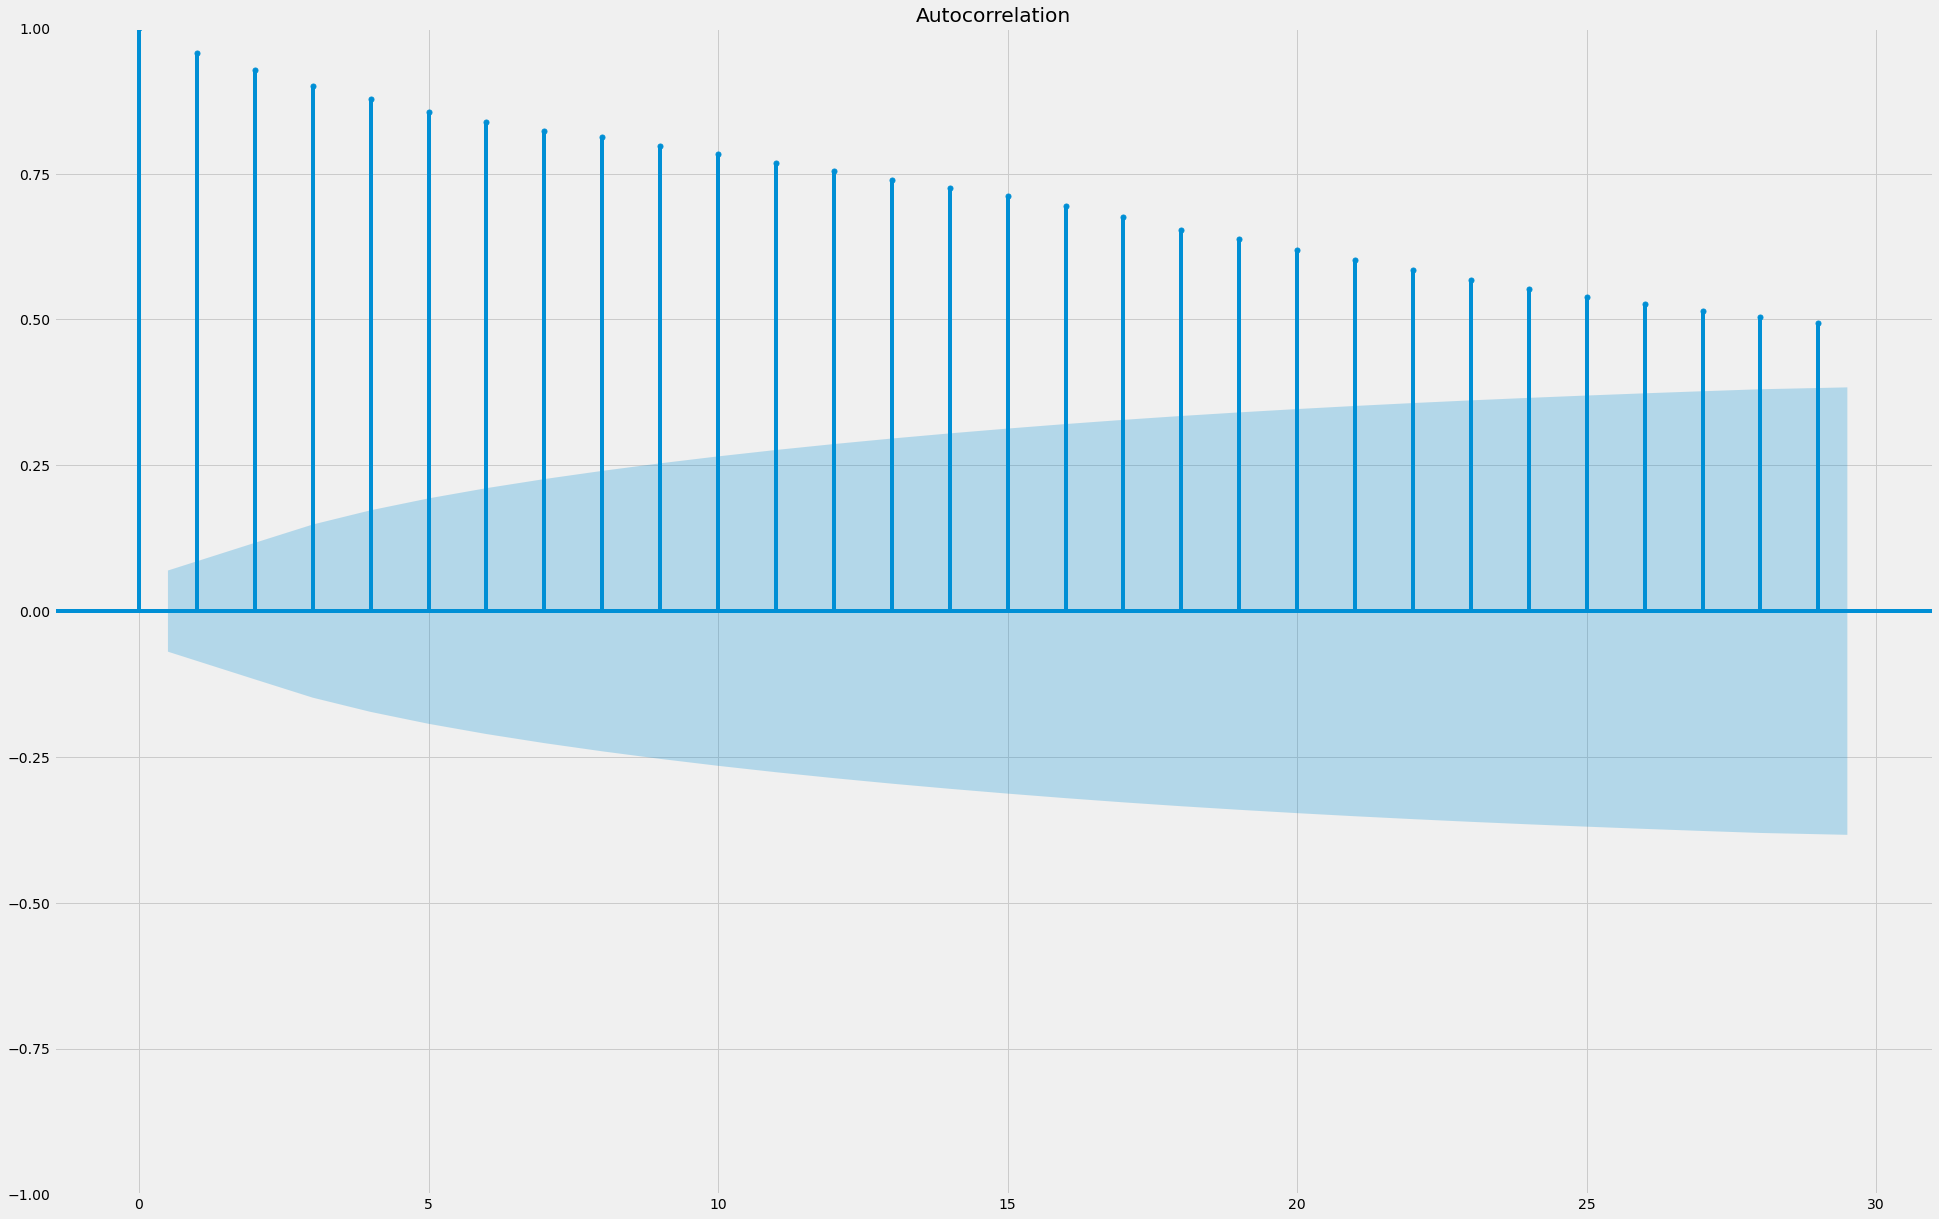

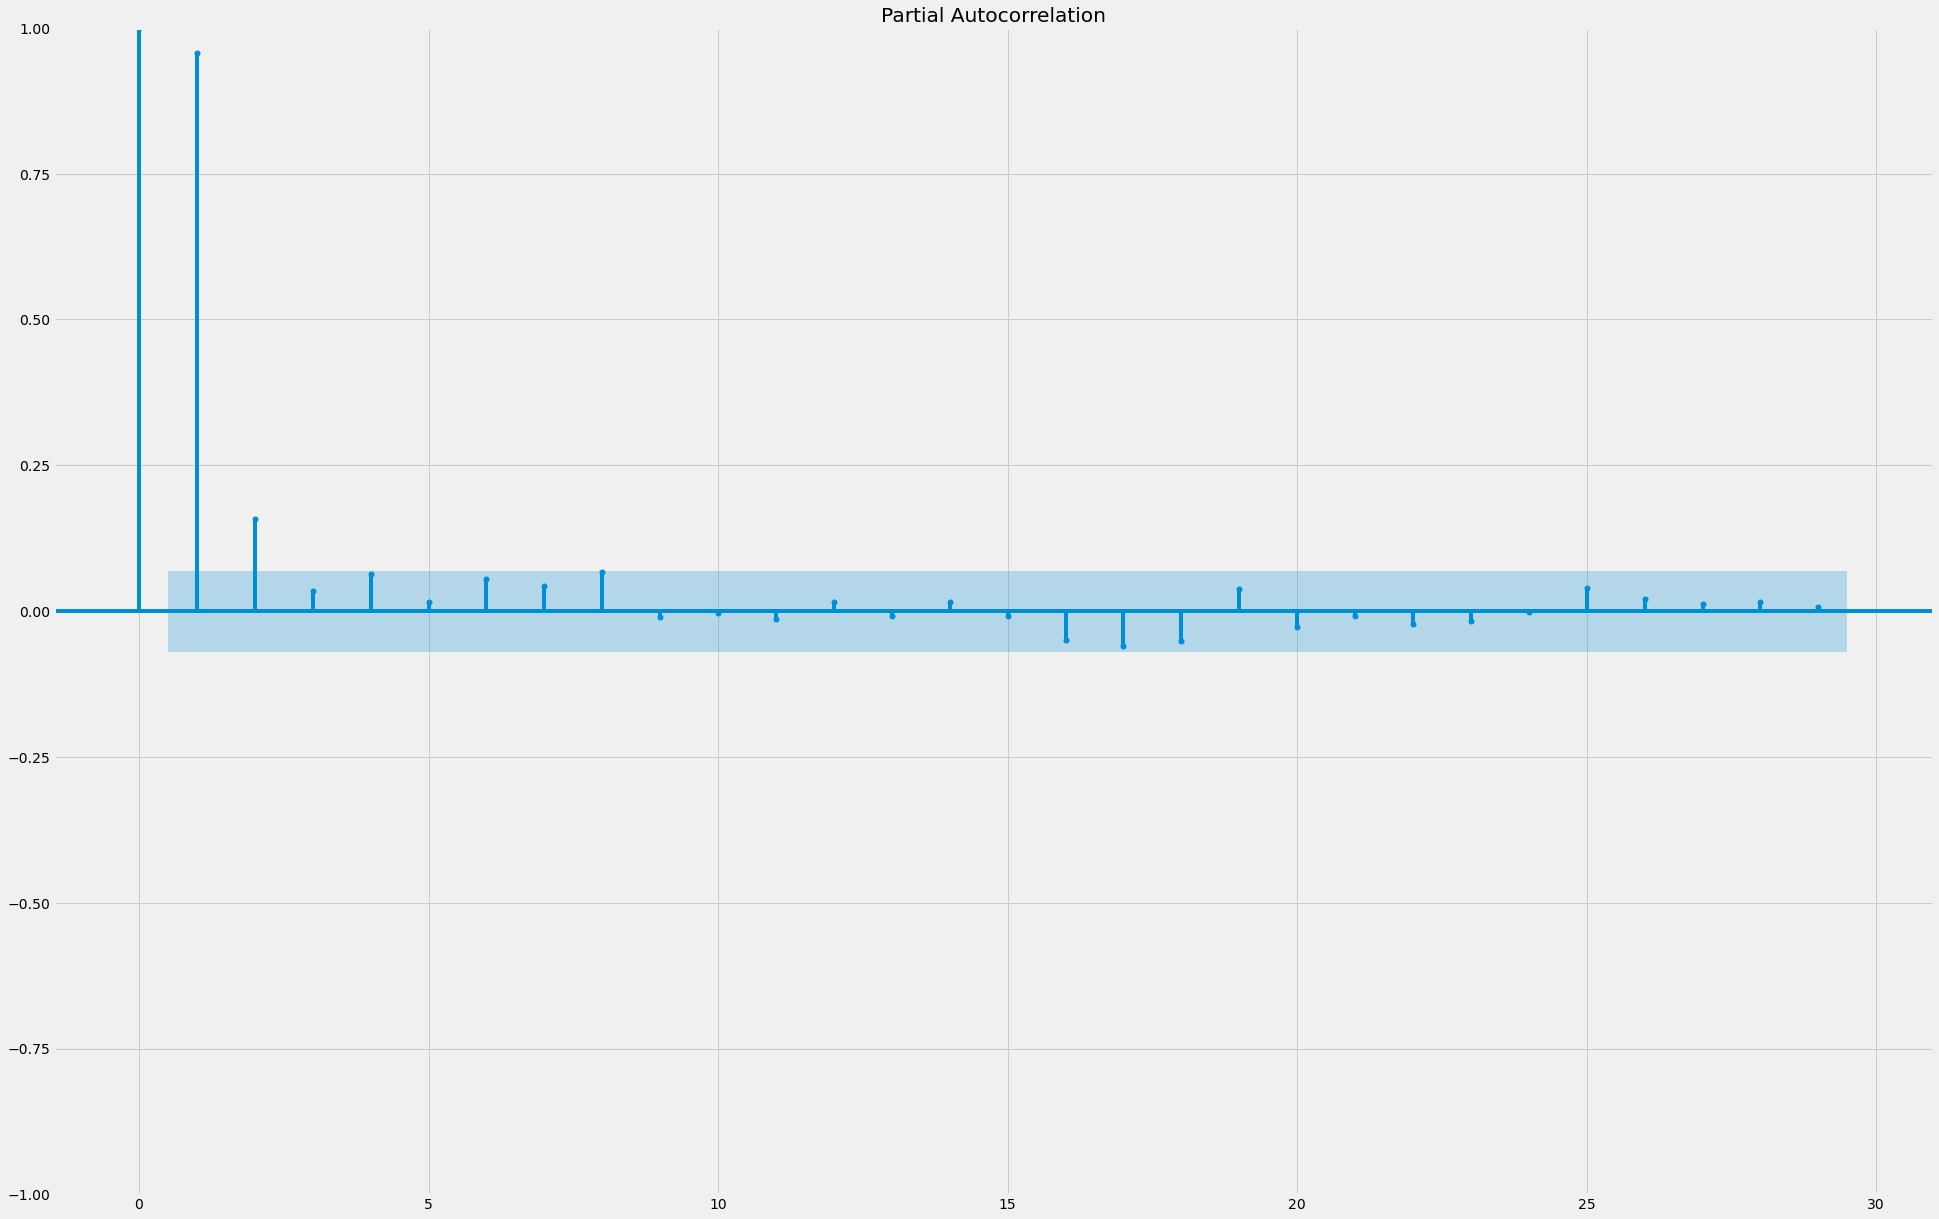

In [16]:
# График автокорреляции
plot_acf(df[CANDLE_DATA]).show()
 
 # Частичный график автокорреляции
plot_pacf(df[CANDLE_DATA]).show() 

По оси абсцисс откладываются сдвиги (включая нулевой сдвиг), по оси ординат - значения коэффициентов автокорреляции. Синим фоном изображены пределы погрешности, прибавленные к нулевым значениям коэффициентов автокорреляции. Таким образом, если коэффициент автокорреляции выходит за пределы синего фона, то он является значимым.

Для нестационарного временного ряда значение в первом лаге, т.е. ACF(1), близко к единице, а затем график автокорреляционной функции медленно затухает. Если ряд содержит тренд, то коэффициент автокорреляции значителен для первых нескольких сдвигов ряда, а в дальнейшем медленно стремится к нулю. Если ряд содержит сезонную компоненту, то коэффициент автокорреляции будет большим для значений сдвига, равных периоду сезонной составляющей или кратных ему. 

 #### Для стационарного временного ряда, независимо от значений в первом лаге, график автокорреляционной функции быстро затухает после несколько первых значений.
 
  #### Для определения того насколько ряд близок к стационарному, обычно используется только график ACF.
 ####  Примеры того как выглядят графики рядов разного типа:

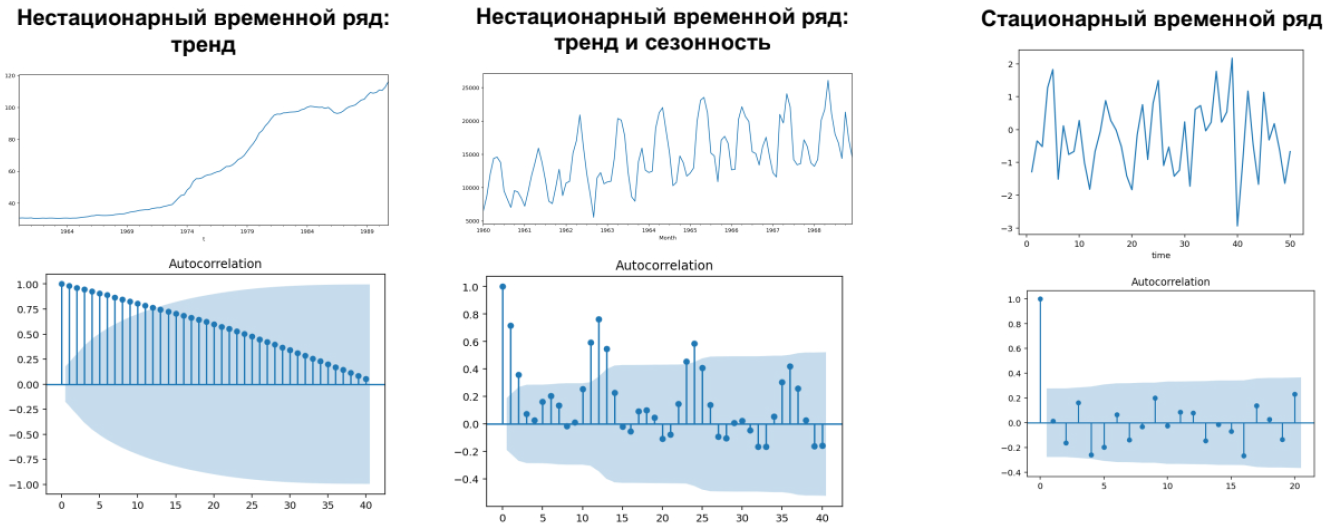